# Imports

In [1]:
import copy
import numpy as np
import itertools
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pixiedust

Pixiedust database opened successfully


# Introduction

Consider the following equation:
$$\Delta_p \Psi(x,y)=f(x,y)$$

$x \in [0,1],\ y \in [0,1]$ with *Dirichlet* BC: $\Psi(0,y) = 0$, $\Psi(1,y) = 0$, $\Psi(x,0) = 0$ and $\Psi(x,1) = 0$.

For this first attempt, we will take $p=2$.

# Defining functions

## Sigmoid

Sigmoid $\sigma(x) = \frac{1}{1+e^{-x}}$ and its derrivatives.

Sigmoid with parameter $t$
$$ \sigma_t(x) = \frac{1}{1+e^{-tx}}$$

In [2]:
T = 1

In [3]:
def sig(x):
    return 1 / (1 + np.exp(-T*x))

def sig1(x):
    return T * sig(x) * (1 - sig(x))

def sig2(x):
    return T * (sig1(x) - 2*sig(x)*sig1(x))

def sig3(x):
    return T * (sig2(x) - 2 * (sig1(x)**2 + sig(x) * sig2(x)))

def sig_pr(x, k):
    if k==0:
        return sig(x)
    if k==1:
        return sig1(x)
    if k==2:
        return sig2(x)
    if k==3:
        return sig3(x)

## RHS

The right side of the equation:  $\Delta\Psi(x,y) = 6 x (x-1) (1-2 y) + 2 y (y-1) (1-2 y)$

In [4]:
K=1
def f(x, y):
    return K * (6*(x-1)*x*(1-2*y) + 2*(y-1)*y*(1-2*y))

The analytic solution is given by: $\ \Psi_a(x,y) = x (1-x) y (1-y) (1-2 y)$

In [5]:
def psi_a(x, y):
    return K * x*(1-x)*y*(1-y)*(1-2*y)

$$\frac{\partial}{\partial x} \Psi_a = (1-2x) y (1-y) (1-2 y)$$

In [6]:
def psi_a_dx(x,y):
    return K * (1-2*x)*y*(1-y)*(1-2*y)

$$\frac{\partial}{\partial y} \Psi_a = x (1-x) (1-6y + 6y^2) $$

In [7]:
def psi_a_dy(x,y):
    return K * x*(1-x)*(1-6*y+6*(y**2))

## Neural Network

The output of neural network $N(x,y,\vec{p})$, where $\vec{p} = [w, u, v]$:
$$N = \sum_i^H v_i \sigma(z_i) \text{, where } z_i = w_{i0} x + w_{i1} y + u_i$$

In [8]:
def z(x, y, p):
    z_x = np.multiply(x, p[0][0])
    z_y = np.multiply(y, p[0][1])
    z_ = np.array([z_x, z_y, p[1]]).sum(axis=0)
    return z_

def N(x, y, p):
    return np.sum(np.multiply(sig(z(x,y,p)), p[2]))

$$\frac{\partial^k N}{\partial x_j^k} = \sum_{i=1}^H v_i w_{ij}^k \sigma^{(k)}$$

In [9]:
def dN_dxj_k(x, y, p, j, k):
    wj = p[0][j]
    v = p[2]
    z_ = z(x, y, p)
    
    return np.sum(v * (wj**k) * sig_pr(z_, k))

$$\frac{\partial N}{\partial w_j} = x_j v \sigma '$$

In [10]:
def dN_dwj(x, y, p, j):
    xj = x if j==0 else y
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * sig1(z_)

$$ \frac{\partial}{\partial w_j} \frac{\partial N}{\partial x_k} = x_j v w_k \sigma'' + v_i \sigma' \quad\text{ if } j = k$$

$$ \frac{\partial}{\partial w_j} \frac{\partial N}{\partial x_k} = x_j v w_k \sigma'' \quad\text{ if } j \neq k$$

In [11]:
def d_dwj_dN_dxk(x, y, p, j, k):
    xj = x if j==0 else y
    wk = p[0][k]
    jk = 1 if j==k else 0
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * wk * sig2(z_) + jk * v * sig1(z_)

$$ \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x_k^2} = x_j v w_k^2 \sigma^{(3)} + 2 v w_k \sigma'' \quad\text{ if } j = k $$

$$ \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x_k^2} = x_j v w_k^2 \sigma^{(3)} \quad\text{ if } j \neq k $$

In [12]:
def d_dwj_dN2_dxk2(x, y, p, j, k):
    xj = x if j==0 else y
    wk = p[0][k]
    jk = 1 if j==k else 0
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * (wk**2) * sig3(z_) + jk * 2 * v * wk * sig2(z_)

$$ \frac{\partial}{\partial u} \frac{\partial^k}{\partial x_j^k} N = v w_j^k \sigma^{(k+1)} $$

In [13]:
def d_du_dkN(x, y, p, j, k):
    v = p[2]
    wj = p[0][j]
    z_ = z(x, y, p)
    return v * (wj**k) * sig_pr(z_, k+1)

$$ \frac{\partial}{\partial v} \frac{\partial^k}{\partial x_j^k} N = w_j^k \sigma^{(k)} $$

In [14]:
def d_dv_dkN(x, y, p, j, k):
    wj = p[0][j]
    z_ = z(x, y, p)
    return (wj**k) * sig_pr(z_, k)

## Trial solution

The trial solution is given by: $$\Psi_t(x,y) = x(1-x)y(1-y)N(x,y,\vec{p})$$

In [15]:
def psi_t(x, y, p):
    return x * (1-x) * y * (1-y) * N(x, y, p)

$$\frac{\partial \Psi_t}{\partial x_j} = y_j(1-y_j)\left[ (1-2x_j) N + x_j (1-x_j) \frac{\partial N}{\partial x_j} \right]$$

In [16]:
def dPsi_dxj(x, y, p, j):
    xj = x if j==0 else y
    yj = y if j==0 else x
    return yj*(1-yj)*((1-2*xj)*N(x,y,p) + xj*(1-xj)*dN_dxj_k(x,y,p,j,1))

$$\frac{\partial^2 \Psi_t}{\partial x_j^2} = y_j(1-y_j)\left[ -2N + (2-4x_j) \frac{\partial N}{\partial x_j} + x_j (1-x_j) \frac{\partial^2 N}{\partial x_j^2} \right]$$

In [17]:
def dPsi2_dxj2(x, y, p, j):
    xj = x if j==0 else y
    yj = y if j==0 else x
    return yj*(1-yj)*(-2*N(x,y,p) + (2-4*xj)*dN_dxj_k(x,y,p,j,1) + xj*(1-xj)*dN_dxj_k(x,y,p,j,2))

## Cost function

$$E[\vec{p}] = \sum_{i \in \hat{D}} \left\{ \frac{\partial^2 \Psi_t}{\partial x^2} + \frac{\partial^2 \Psi_t}{\partial y^2} - f(x,y) \right\}^2 $$

In [18]:
def error(x, y, p):
    return dPsi2_dxj2(x,y,p,0) + dPsi2_dxj2(x,y,p,1) - f(x,y)

In [19]:
def cost(points, p):
    err = []
    for x, y in points:
        err_sq = error(x, y, p)**2
        err.append(err_sq)
        
    cost = sum(err)
    
    return cost

In [20]:
def relative_err(p, nx=100, all_points=None):
    if all_points == None:
        all_points = list(itertools.product(np.linspace(0, 1, nx), np.linspace(0, 1, nx)))

    dOmega = 1. / len(all_points)

    trial1 = np.sum(dOmega*np.array([np.linalg.norm(psi_t(x,y,p) - psi_a(x,y))**2
                                     for x, y in all_points]))

    trial2 = np.sum([dOmega*((dPsi_dxj(x,y,p,0)-psi_a_dx(x,y))**2 +
                             (dPsi_dxj(x,y,p,1)-psi_a_dy(x,y))**2)
                     for x, y in all_points])

    ana1 = np.sum(dOmega*np.array([np.linalg.norm(psi_a(x,y))**2
                                         for x, y in all_points]))
    ana2 = np.sum([dOmega*(psi_a_dx(x,y)**2 + psi_a_dy(x,y)**2)
                   for x, y in all_points])
    
    rel_err = (trial1 + trial2)**(1/2) / (ana1 + ana2)**(1/2)
    
    return rel_err

# Gradients

$$\frac{\partial}{\partial w_j} \frac{\partial^2 \Psi_t}{\partial x_k^2} = y_k(1-y_k)\left[ -2\frac{\partial N}{\partial w_j} + (2-4x_k) \frac{\partial}{\partial w_j} \frac{\partial N}{\partial x_k} + x_k(1-x_k) \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x_k^2} \right]$$

In [21]:
def d_dwj_dPsi2_dxk2(x, y, p, j, k):
    xj = x if k==0 else y
    yj = y if k==0 else x
    return yj*(1-yj)*(-2*dN_dwj(x,y,p,j) + (2-4*xj)*d_dwj_dN_dxk(x,y,p,j,k) + xj*(1-xj)*d_dwj_dN2_dxk2(x,y,p,j,k))

$$\frac{\partial}{\partial u} \frac{\partial^2 \Psi_t}{\partial x_k^2} = y_k(1-y_k)\left[ -2\frac{\partial N}{\partial u} + (2-4x_k) \frac{\partial}{\partial u} \frac{\partial N}{\partial x_k} + x_k(1-x_k) \frac{\partial}{\partial u} \frac{\partial^2 N}{\partial x_k^2} \right]$$

In [22]:
def d_du_dPsi2_dxk2(x, y, p, k):
    xj = x if k==0 else y
    yj = y if k==0 else x
    return yj*(1-yj)*(-2*d_du_dkN(x,y,p,k,0) + (2-4*xj)*d_du_dkN(x,y,p,k,1) + xj*(1-xj)*d_du_dkN(x,y,p,k,2))

$$\frac{\partial}{\partial v} \frac{\partial^2 \Psi_t}{\partial x_k^2} = y_k(1-y_k)\left[ -2\frac{\partial N}{\partial v} + (2-4x_k) \frac{\partial}{\partial v} \frac{\partial N}{\partial x_k} + x_k(1-x_k) \frac{\partial}{\partial v} \frac{\partial^2 N}{\partial x_k^2} \right]$$

In [23]:
def d_dv_dPsi2_dxk2(x, y, p, k):
    xj = x if k==0 else y
    yj = y if k==0 else x
    return yj*(1-yj)*(-2*d_dv_dkN(x,y,p,k,0) + (2-4*xj)*d_dv_dkN(x,y,p,k,1) + xj*(1-xj)*d_dv_dkN(x,y,p,k,2))

$$ \frac{\partial E[\vec{p}]}{\partial w_j} = \sum_{i \in \hat{D}} \left\{ 2 \text{ (error) } \left( \frac{\partial}{\partial w_j} \frac{\partial^2 \Psi_t}{\partial x^2} + \frac{\partial}{\partial w_j} \frac{\partial^2 \Psi_t}{\partial y^2} \right) \right\}$$

In [24]:
def dE_dwj(points, p, j):
    t1 = []
    for x, y in points:
        tmp = 2 * error(x,y,p) * (d_dwj_dPsi2_dxk2(x,y,p,j,0) + 
                                  d_dwj_dPsi2_dxk2(x,y,p,j,1))
        t1.append(tmp)
    
    grad = sum(t1)
    
    return grad

$$ \frac{\partial E[\vec{p}]}{\partial u} = \sum_{i \in \hat{D}} \left\{ 2 \text{ (error) } \left( \frac{\partial}{\partial u} \frac{\partial^2 \Psi_t}{\partial x^2} + \frac{\partial}{\partial u} \frac{\partial^2 \Psi_t}{\partial y^2} \right) \right\}$$

In [25]:
def dE_du(points, p):
    t1 = []
    for x, y in points:
        tmp = 2 * error(x,y,p) * (d_du_dPsi2_dxk2(x,y,p,0) + 
                                  d_du_dPsi2_dxk2(x,y,p,1))
        t1.append(tmp)
    
    grad = sum(t1)
    
    return grad

$$ \frac{\partial E[\vec{p}]}{\partial v} = \sum_{i \in \hat{D}} \left\{ 2 \text{ (error) } \left( \frac{\partial}{\partial v} \frac{\partial^2 \Psi_t}{\partial x^2} + \frac{\partial}{\partial v} \frac{\partial^2 \Psi_t}{\partial y^2} \right) \right\}$$

In [26]:
def dE_dv(points, p):
    t1 = []
    for x, y in points:
        tmp = 2 * error(x,y,p) * (d_dv_dPsi2_dxk2(x,y,p,0) + 
                                  d_dv_dPsi2_dxk2(x,y,p,1))
        t1.append(tmp)
    
    grad = sum(t1)
    
    return grad

# NN class

In [27]:
def initialize_p(hidden_nodes):
    w1 = np.random.randn(hidden_nodes)
    v = np.random.randn(hidden_nodes)
    w0 = []
    u = []

    for w1_sample in w1:
        x = []
        y = []
        for side in np.random.choice(4, 2, replace=False):
            if side == 0:
                x.append(0)
                y.append(np.random.uniform(0.1,0.9,1)[0])
            elif side == 1:
                x.append(np.random.uniform(0.1,0.9,1)[0])
                y.append(1)
            elif side == 2:
                x.append(1)
                y.append(np.random.uniform(0.1,0.9,1)[0])
            elif side == 3:
                x.append(np.random.uniform(0.1,0.9,1)[0])
                y.append(0)

        slope = (y[1] - y[0]) / (x[1] - x[0])
        w0.append(-slope * w1_sample)
        u.append((slope*x[0] - y[0]) * w1_sample)

    p = np.array([np.array([np.array(w0), np.array(w1)]), 
                  np.array(u), np.array(v)])
    
    return p

In [28]:
def get_mini_batches(points, batch_size):
    np.random.shuffle(points)
    
    no_of_splits = np.ceil(len(points) / batch_size)

    mini_batch_points = np.array_split(points, no_of_splits)
    
    return mini_batch_points

In [29]:
class NNTrain:
    def __init__(self, nx=10, hidden_nodes=10, alpha=0.01, batch_size=50,
                 beta=0.9, update_interval=50, if_rel_err=False,
                 output_file='output/output.csv'):

        self.output_file = output_file
        self.training_started = False
        self.nx = nx
        self.hidden_nodes = hidden_nodes
        self.alpha = alpha
        self.batch_size = batch_size
        self.beta = beta
        self.update_interval = update_interval
        self.points = list(itertools.product(
            np.linspace(0, 1, nx), np.linspace(0, 1, nx)))
        self.cost_rate = []
        self.if_rel_err = if_rel_err
        if self.if_rel_err:
            self.rel_err = []
        self.p = initialize_p(hidden_nodes)
        self.m_t = np.array([np.zeros(hidden_nodes),
                             np.zeros(hidden_nodes),
                             np.zeros(hidden_nodes),
                             np.zeros(hidden_nodes)])

        
    def sgd_mt(self, w, g_t, theta_0):
        # gradient descent with momentum
        self.m_t[w] = self.beta * self.m_t[w] + (1-self.beta) * g_t
        theta_0 = theta_0 - (self.alpha*self.m_t[w])

        return theta_0

    
    def train(self, itr=1000):
        if self.training_started:
            mode = 'a'
        else:
            mode = 'w'
        self.training_started = True

        with open(self.output_file, mode) as file:
            if mode == 'w':
                if self.if_rel_err:
                    file.write(
                        'Iteration,Cost,Cost Diff,Relative Error,Relative Error Diff\n')
                else:
                    file.write('Iteration,Cost,Cost Diff\n')
            start = len(self.cost_rate)-1
            if start < 1:
                start += 1
                self.cost_rate.append(cost(self.points, self.p))
                if self.if_rel_err:
                    self.rel_err.append(relative_err(
                        self.p, all_points=self.points))

            i = start
            while i < start+itr:
                mini_batch_points = get_mini_batches(
                    self.points, self.batch_size)

                for mini_point in mini_batch_points:
                    mini_point = list(mini_point)

                    g_w0 = dE_dwj(mini_point, self.p, 0)
                    g_w1 = dE_dwj(mini_point, self.p, 1)
                    g_u = dE_du(mini_point, self.p)
                    g_v = dE_dv(mini_point, self.p)

                    self.p[0][0] = self.sgd_mt(0, g_w0, self.p[0][0])
                    self.p[0][1] = self.sgd_mt(1, g_w1, self.p[0][1])
                    self.p[1] = self.sgd_mt(2, g_u, self.p[1])
                    self.p[2] = self.sgd_mt(3, g_v, self.p[2])

                self.cost_rate.append(cost(self.points, self.p))
                cost_diff = self.cost_rate[i]-self.cost_rate[i+1]
                if self.if_rel_err:
                    self.rel_err.append(relative_err(
                        self.p, all_points=self.points))
                    rel_diff = self.rel_err[i]-self.rel_err[i+1]

                if self.if_rel_err:
                    file.write('{},{:.8f},{:.8f},{:.8f},{:.8f}\n'.format(
                        i+1, self.cost_rate[i+1], cost_diff,
                        self.rel_err[i+1], rel_diff))
                else:
                    file.write('{},{:.8f},{:.8f}\n'.format(
                        i+1, self.cost_rate[i+1], cost_diff))

                if i % self.update_interval == 0:
                    file.flush()

                i += 1

                
    def save_result(self, output_name=''):
        timestr = time.strftime("%Y%m%d-%H%M")
        np.savez('output/' + timestr + '_' +
                 output_name + '_nn_params.npz', self.p)
        np.savez('output/' + timestr + '_' + output_name +
                 '_cost_rate.npz', self.cost_rate)
        if self.if_rel_err:
            np.savez('output/' + timestr + '_' +
                     output_name + '_rel_err.npz', self.rel_err)

# Graphs

In [30]:
%matplotlib notebook
%matplotlib notebook

## Hidden Nodes

In [31]:
def plot_nodes(a, save_name=None, save=True, zlim=True):
    p = a.p
    hmax = a.p[0][0].shape[0]
    col = int(np.sqrt(hmax)) if int(np.sqrt(hmax)) < 10 else 10
    row = np.ceil(hmax / col)
    
    d_x=0.1

    fig = plt.figure(figsize=(col*3, row*3), dpi=100)
    for h in range(1,hmax+1):
        ax = fig.add_subplot(row,col,h, projection='3d')
        x = y = np.arange(0, 1+d_x, d_x)
        X, Y = np.meshgrid(x, y)

        zs = np.array([p[1][h-1]*sig(z(x,y,p))[h-1] for x,y in zip(np.ravel(X), np.ravel(Y))])
        Z = zs.reshape(X.shape)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        if zlim:
            ax.set_zlim(0,1)

        ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
        ax.title.set_text('HN: ' + str(h) + ', v=' + "{:.4E}".format(p[1][h-1]))
        time.sleep(0.2)

    if save==True:
        if save_name is None: 
            plt.savefig('t'+str(T)+'_h'+str(hmax)+'_n'+str(a.nx)+'.png')
        else:
            plt.savefig(save_name)
    else:
        plt.show()

## Error vs Iterations

In [32]:
def plot_iteration(arr, min_it=0, max_it=None):
    plt.figure()
    plt.plot(np.arange(len(arr[min_it:max_it])), np.array(arr[min_it:max_it]))
    plt.show()

## Solution Accuracy on the domain

In [33]:
def plot_fun(fun, zlim=False, title=None, return_ax=False, **kwargs):
    d_x=0.01
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 1.0+d_x, d_x)
    X, Y = np.meshgrid(x, y)

    zs = np.array([fun(x,y,**kwargs) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm_r)
    # ax.ticklabel_format(style='sci', axis='z', scilimits=(0,0), useOffset=True, useMathText=True)


    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.title.set_text(title)
    
    if zlim:
        ax.set_zlim(0,1)

    if return_ax:
        return ax
    else:
        plt.show()

In [34]:
def plot_partitions(p):
    plt.plot([0,0,1,1,0], [0,1,1,0,0], linewidth=3)

    for HN in range(len(p[1])):
        x = np.linspace(-1,2,500)
        y = -(p[1][HN] + p[0][0][HN]*x) / p[0][1][HN]

        plt.plot(x, y, label=HN)

    plt.xlim(-1,2)
    plt.ylim(-1,2)

# Training

In [35]:
K=10
a = NNTrain(nx=60, hidden_nodes=75, alpha=1e-4, batch_size=50, update_interval=10, if_rel_err=True, output_file='out/out7.csv')

In [ ]:
p=[]
p.append(copy.deepcopy(a.p))
a.train(100)

In [ ]:
thresh=1e-5

for i in range(10000):
    p.append(copy.deepcopy(a.p))
    if np.mean([np.abs(s-t) for s, t in zip(a.cost_rate[-21:], a.cost_rate[-20:])]) < thresh:
        break
    a.train(100)

Etc

In [39]:
print('relative error:', relative_err(a.p, nx=100))

relative error: 0.0007525949442626524


<IPython.core.display.Javascript object>


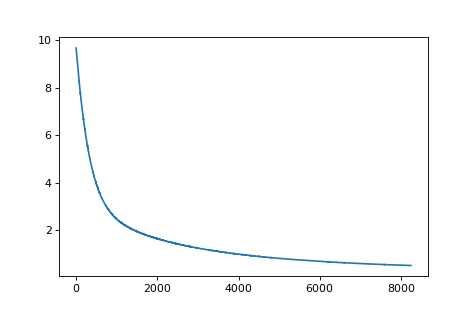

In [40]:
plot_iteration(a.cost_rate, min_it=1000)

<IPython.core.display.Javascript object>


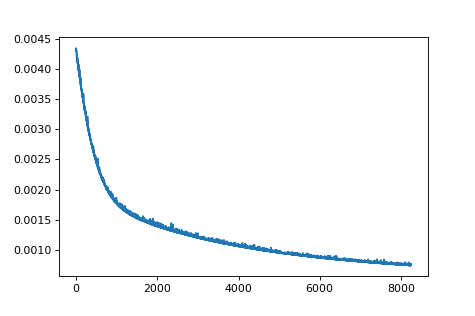

In [41]:
plot_iteration(a.rel_err, min_it=1000)

In [ ]:
p1 = np.load('output/20191223-1714_eq1_1_nn_params.npz')['arr_0']
p2 = np.load('output/20191223-1714_eq1_2_nn_params.npz')['arr_0']
p3 = np.load('output/20191223-1714_eq1_3_nn_params.npz')['arr_0']
p4 = np.load('output/20191223-1730_eq1_4_nn_params.npz')['arr_0']
p5 = np.load('output/20191223-1730_eq1_5_nn_params.npz')['arr_0']
p6 = np.load('output/20191223-1731_eq1_6_nn_params.npz')['arr_0']
p7 = np.load('output/20191223-1731_eq1_7_nn_params.npz')['arr_0']

In [ ]:
plot_partitions(p1)

In [42]:
name_str = 'L97_eq1_7_v1'
a.save_result(name_str)

timestr = time.strftime("%Y%m%d-%H%M")
np.savez('output/'+ timestr + '_' + name_str + '_momentum.npz', a.m_t)
np.savez('output/'+ timestr + '_' + name_str + '_p_list.npz', p)

In [ ]:
name_str = '20200716-2122_eq1_1'

a.p = np.load('output/' + name_str + '_v1_nn_params.npz')['arr_0']
a.cost_rate = np.load('output/' + name_str + '_v1_cost_rate.npz')['arr_0']
a.rel_err = np.load('output/' + name_str + '_v1_rel_err.npz')['arr_0']
a.m_t = np.load('output/' + name_str + '_v1_momentum.npz')['arr_0']
p = np.load('output/' + name_str + '_v1_p_list.npz')['arr_0']